In [1]:
import copy as cp
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append('../')

from src.HydraulicConductanceModels.cumulative_Weibull_distribution_model import cumulative_Weibull_distribution_from_conductance_loss_at_given_water_potentials, CumulativeWeibullDistribution

## Create the conductance model

Plots included to check the cumulative Weibull distribution is correct.

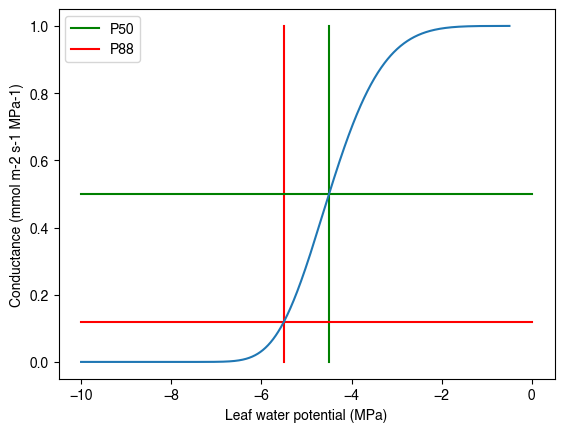

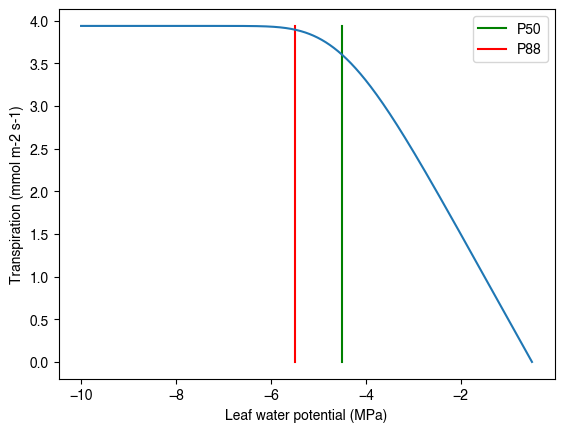

In [2]:
# Conductance model
P50 = -4.5 #-4.739999999999999 # MPa
P88 = -5.5 #-5.476604474129552 # MPa
k_max = 1 # mmol m-2 s-1 MPa-1

conductance_model = cumulative_Weibull_distribution_from_conductance_loss_at_given_water_potentials(k_max,
                                                                                                    P50,
                                                                                                    P88,
                                                                                                    0.5,
                                                                                                    0.88)

leaf_psi_array = np.linspace(-0.5,-10., 1000)
k_array = np.zeros(len(leaf_psi_array))
e_array = np.zeros(len(leaf_psi_array))

for i in range(len(leaf_psi_array)):
    k_array[i] = conductance_model.conductance(leaf_psi_array[i])
    e_array[i] = conductance_model.transpiration(leaf_psi_array[i], -0.5)
    
plt.plot([P50,P50],[0,1], color = 'g', label = 'P50')
plt.plot([P88,P88],[0,1], color = 'r', label = 'P88')
plt.plot([0.,-10.],[0.5,0.5], color = 'g')
plt.plot([0.,-10.],[0.12,0.12], color = 'r')
plt.plot(leaf_psi_array, k_array)
plt.xlabel('Leaf water potential (MPa)')
plt.ylabel('Conductance (mmol m-2 s-1 MPa-1)')
plt.legend()
plt.show()

plt.plot([P50,P50],[0,e_array[-1]], color = 'g', label = 'P50')
plt.plot([P88,P88],[0,e_array[-1]], color = 'r', label = 'P88')
plt.plot(leaf_psi_array, e_array)
plt.xlabel('Leaf water potential (MPa)')
plt.ylabel('Transpiration (mmol m-2 s-1)')
plt.legend()
plt.show()

## Calc Psi from transpiration

The function in the code block bellow is areproduction of the aproximation in M. De Kauwe 2022.

In [3]:
def calc_psi_leaf(psi_sat, e_leaf, conductance_model, acc, N, k_min = 0.0001, debug = False):
    
    k_current = conductance_model.conductance(psi_sat)
    
    psi_leaf = cp.copy(psi_sat)
    
    for itter in range(N):
        
        # Needed to avoid divide by zero.
        if k_current < k_min:
            return np.nan
        
        if debug:
            print("\n -- ", itter, " -- ")
            print("k_current: ", k_current)
            print("psi_current: ", psi_leaf)
        
        k_old = cp.copy(k_current)
        
        psi_leaf = psi_sat - (e_leaf / k_current)
        
        k_current = conductance_model.conductance(psi_leaf)
        
        if np.abs(k_current - k_old) < acc :
            if debug:
                print("k_out: ", k_current)
                print("n = ", itter, " of ", N)
            return psi_leaf
        
       
        
    if debug:
        print("n = ", itter, " of ", N)
    return psi_leaf
        

## Single psi test

In [4]:
leaf_psi_true = -3.0 # MPa
root_psi = -0.5 # MPa

e_leaf = conductance_model.transpiration(leaf_psi_true, root_psi, steps = 1000)
k_true = conductance_model.conductance(leaf_psi_true)

print("True conductance: ", k_true)
print("Transpiration: ", e_leaf)

acc = 0.00001 # MPa
N = 100

leaf_psi_predicted = calc_psi_leaf(root_psi, e_leaf, conductance_model, acc, N, debug = True)

print("\nPredicted psi: ", leaf_psi_predicted, " MPa")

True conductance:  0.9301618686255714
Transpiration:  2.467587186561953

 --  0  -- 
k_current:  0.9999966566335279
psi_current:  -0.5

 --  1  -- 
k_current:  0.9341241646867382
psi_current:  -2.9675954366378026

 --  2  -- 
k_current:  0.9106384374835754
psi_current:  -3.141605131143853

 --  3  -- 
k_current:  0.8998790539366606
psi_current:  -3.209733177286907

 --  4  -- 
k_current:  0.8944319930896897
psi_current:  -3.2421320407082597

 --  5  -- 
k_current:  0.8915390290545496
psi_current:  -3.2588315328905217

 --  6  -- 
k_current:  0.8899639834123387
psi_current:  -3.2677836933047733

 --  7  -- 
k_current:  0.8890949642597352
psi_current:  -3.2726820776506287

 --  8  -- 
k_current:  0.8886119772783954
psi_current:  -3.2753921524192617

 --  9  -- 
k_current:  0.888342453897236
psi_current:  -3.276900660420512

 --  10  -- 
k_current:  0.8881917117528414
psi_current:  -3.2777431729581674

 --  11  -- 
k_current:  0.8881072969070323
psi_current:  -3.2782146060473627

 --  12 

## Multiple psi test

the bellow tests consists of predicting a set of leaf water potentials from a range of transpirations where the true leaf water potential (and conductance) is known.

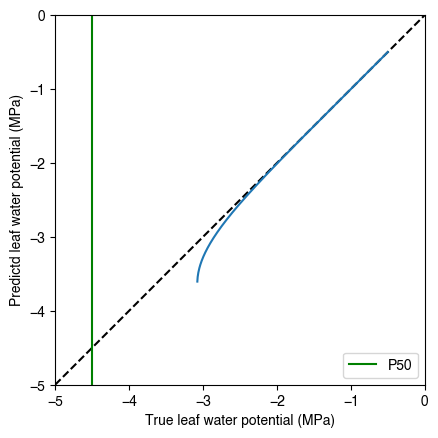

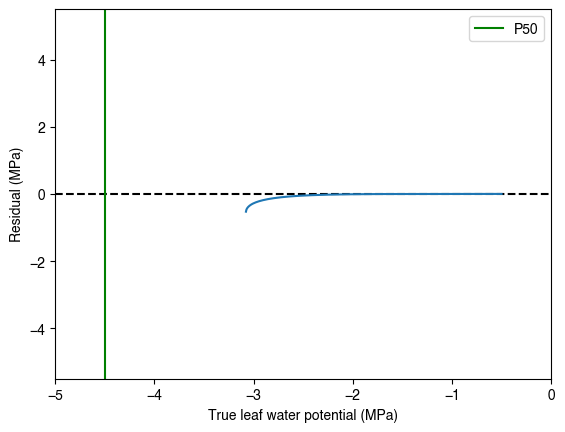

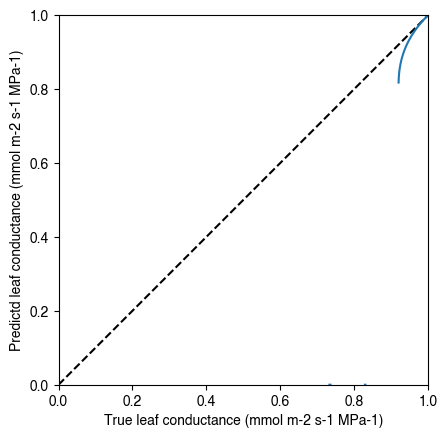

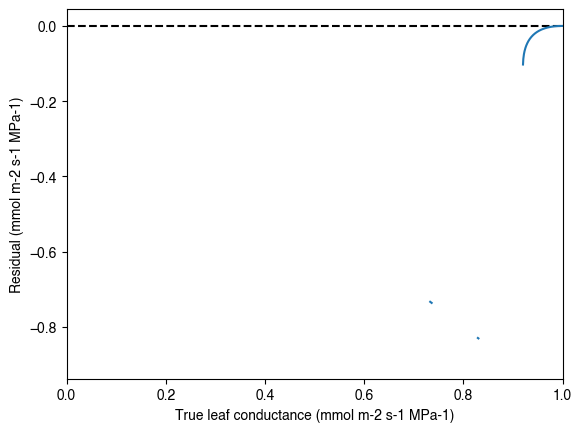

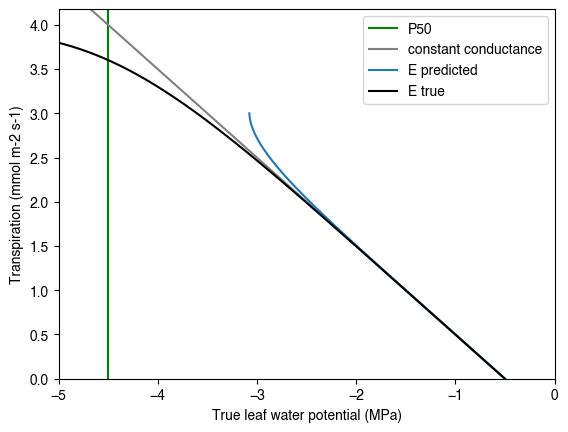

In [5]:
k_min = 0.000001
min_psi = -5.0
root_psi = -0.5 # MPa
leaf_psi_true_array = np.linspace(root_psi, min_psi, 1000)

e_leaf_array = np.zeros(len(leaf_psi_true_array))
k_true_array = np.zeros(len(leaf_psi_true_array))

for i in range(len(leaf_psi_true_array)):
    e_leaf_array[i] = conductance_model.transpiration(leaf_psi_true_array[i], root_psi, steps = 100)
    k_true_array[i] = conductance_model.conductance(leaf_psi_true_array[i])

leaf_psi_predicted_array = np.zeros((len(leaf_psi_true_array)))
k_predicted_array = np.zeros((len(leaf_psi_true_array)))
e_predicted_array = np.zeros((len(leaf_psi_true_array)))

for i in range(len(leaf_psi_true_array)):
    leaf_psi_predicted_array[i] = calc_psi_leaf(root_psi, e_leaf_array[i], conductance_model, acc, N, k_min)
    k_predicted_array[i] = conductance_model.conductance(leaf_psi_predicted_array[i])
    e_predicted_array[i] = conductance_model.transpiration(leaf_psi_predicted_array[i], root_psi, steps = 100)
    

plt.plot([min_psi,0],[min_psi,0], color = 'black', linestyle='--')
plt.plot([P50,P50],[0,min_psi], color = 'g', label = 'P50')
plt.plot(leaf_psi_true_array, leaf_psi_predicted_array)
plt.xlabel('True leaf water potential (MPa)')
plt.ylabel('Predictd leaf water potential (MPa)')
plt.gca().set_aspect('equal')
plt.ylim(min_psi,0)
plt.xlim(min_psi,0)
plt.legend()
plt.show()

plt.plot([min_psi,0],[0,0], color = 'black', linestyle='--')
plt.plot([P50,P50],[1.1*min_psi,-1.1*min_psi], color = 'g', label = 'P50')
plt.plot(leaf_psi_true_array, leaf_psi_predicted_array - leaf_psi_true_array)
plt.xlabel('True leaf water potential (MPa)')
plt.ylabel('Residual (MPa)')
plt.ylim(1.1*min_psi,-1.1*min_psi)
plt.xlim(min_psi,0)
plt.legend()
plt.show()

plt.plot([0.,1.],[0.,1.], color = 'black', linestyle='--')
plt.plot(k_true_array, k_predicted_array)
plt.xlabel('True leaf conductance (mmol m-2 s-1 MPa-1)')
plt.ylabel('Predictd leaf conductance (mmol m-2 s-1 MPa-1)')
plt.gca().set_aspect('equal')
plt.ylim(0.,1.)
plt.xlim(0.,1.)
#plt.legend()
plt.show()

plt.plot([0.,1.],[0,0], color = 'black', linestyle='--')
plt.plot(k_true_array, k_predicted_array - k_true_array)
plt.xlabel('True leaf conductance (mmol m-2 s-1 MPa-1)')
plt.ylabel('Residual (mmol m-2 s-1 MPa-1)')
#plt.ylim(1.1*min_psi,-1.1*min_psi)
plt.xlim(0.,1.)
#plt.legend()
plt.show()

plt.plot([P50,P50],[0,1.1*e_leaf_array[-1]], color = 'g', label = 'P50')
plt.plot([min_psi,leaf_psi_true_array[0]],[k_max*(leaf_psi_true_array[0]-min_psi),0], color = 'grey', label = 'constant conductance')
plt.plot(leaf_psi_true_array, e_predicted_array, label = 'E predicted')
plt.plot(leaf_psi_true_array, e_leaf_array, color = 'black', label = 'E true')
plt.xlabel('True leaf water potential (MPa)')
plt.ylabel('Transpiration (mmol m-2 s-1)')
plt.xlim(min_psi,0)
plt.ylim(0,1.1*e_leaf_array[-1])
plt.legend()
plt.show()

## Vairy P50

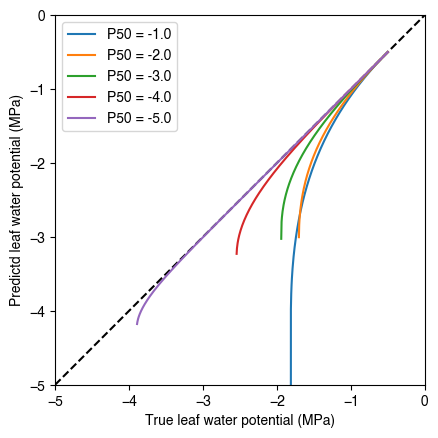

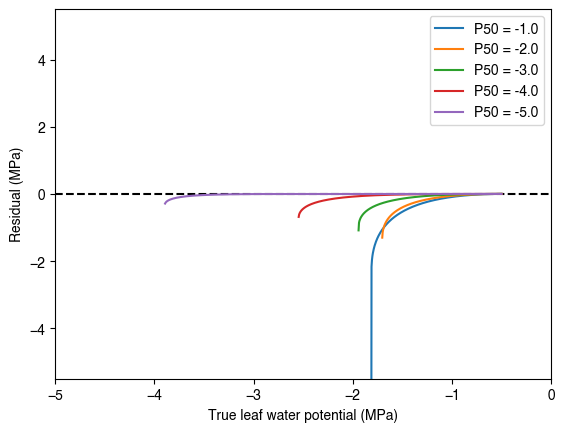

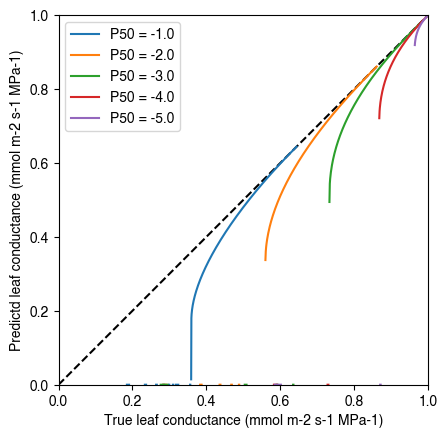

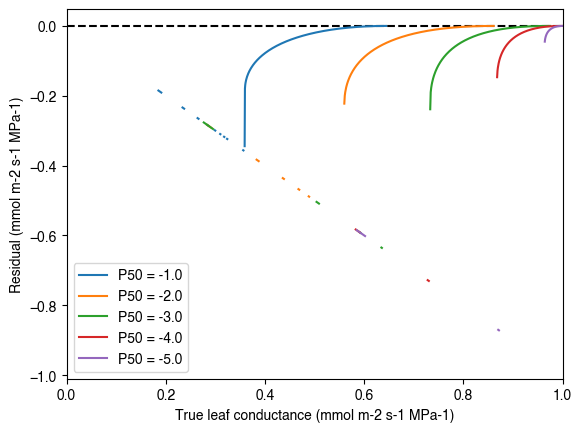

In [6]:
P50_values = np.linspace(-1.,-5., 5)

conductance_models = []

for i in range(len(P50_values)):
    conductance_models.append(cumulative_Weibull_distribution_from_conductance_loss_at_given_water_potentials(k_max,
                                                                                                              P50_values[i],
                                                                                                              P88,
                                                                                                              0.5,
                                                                                                              0.88))

e_leaf_arrays = np.zeros([len(P50_values),len(leaf_psi_true_array)])
k_true_arrays = np.zeros([len(P50_values),len(leaf_psi_true_array)])

for i in range(len(P50_values)):
    for j in range(len(leaf_psi_true_array)):
        e_leaf_arrays[i,j] = conductance_models[i].transpiration(leaf_psi_true_array[j], root_psi, steps = 100)
        k_true_arrays[i,j] = conductance_models[i].conductance(leaf_psi_true_array[j])

leaf_psi_predicted_arrays = np.zeros([len(P50_values),len(leaf_psi_true_array)])
leaf_k_predicted_arrays = np.zeros([len(P50_values),len(leaf_psi_true_array)])

for i in range(len(P50_values)):
    for j in range(len(leaf_psi_true_array)):
        leaf_psi_predicted_arrays[i,j] = calc_psi_leaf(root_psi, e_leaf_arrays[i,j], conductance_models[i], acc, N, k_min)
        leaf_k_predicted_arrays[i,j] = conductance_models[i].conductance(leaf_psi_predicted_arrays[i,j])
        
plt.plot([min_psi,0.],[min_psi,0.], color = 'black', linestyle='--')
for i in range(len(P50_values)):
    plt.plot(leaf_psi_true_array, leaf_psi_predicted_arrays[i], label = 'P50 = ' + str(P50_values[i]))
plt.xlabel('True leaf water potential (MPa)')
plt.ylabel('Predictd leaf water potential (MPa)')
plt.legend()
plt.gca().set_aspect('equal')
plt.ylim(min_psi,0)
plt.xlim(min_psi,0)
plt.show()

plt.plot([min_psi,0.],[0.,0.], color = 'black', linestyle='--')
for i in range(len(P50_values)):
    plt.plot(leaf_psi_true_array, leaf_psi_predicted_arrays[i] - leaf_psi_true_array, label = 'P50 = ' + str(P50_values[i]))
plt.xlabel('True leaf water potential (MPa)')
plt.ylabel('Residual (MPa)')
plt.legend()
plt.ylim(1.1*min_psi,-1.1*min_psi)
plt.xlim(min_psi,0)
plt.show()

plt.plot([0.,1.],[0.,1.], color = 'black', linestyle='--')
for i in range(len(P50_values)):
    plt.plot(k_true_arrays[i], leaf_k_predicted_arrays[i], label = 'P50 = ' + str(P50_values[i]))
plt.xlabel('True leaf conductance (mmol m-2 s-1 MPa-1)')
plt.ylabel('Predictd leaf conductance (mmol m-2 s-1 MPa-1)')
plt.gca().set_aspect('equal')
plt.ylim(0.,1.)
plt.xlim(0.,1.)
plt.legend()
plt.show()

plt.plot([0.,1.],[0,0], color = 'black', linestyle='--')
for i in range(len(P50_values)):
    plt.plot(k_true_arrays[i], leaf_k_predicted_arrays[i] - k_true_arrays[i], label = 'P50 = ' + str(P50_values[i]))
plt.xlabel('True leaf conductance (mmol m-2 s-1 MPa-1)')
plt.ylabel('Residual (mmol m-2 s-1 MPa-1)')
#plt.ylim(1.1*min_psi,-1.1*min_psi)
plt.xlim(0.,1.)
plt.legend()
plt.show()

## Vairy P88

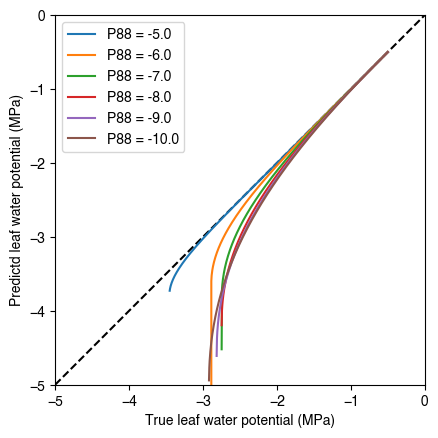

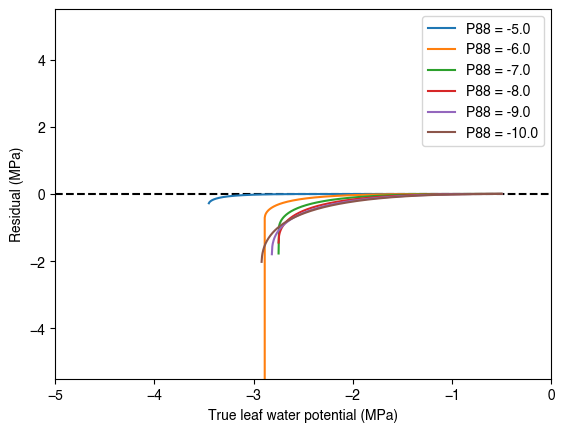

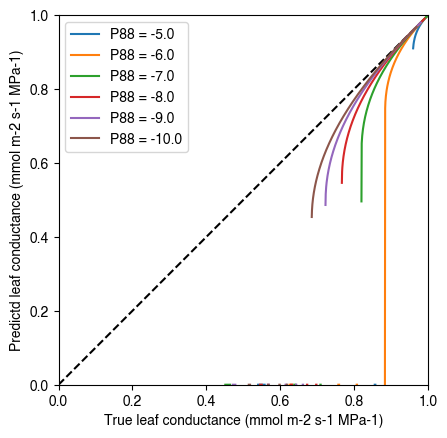

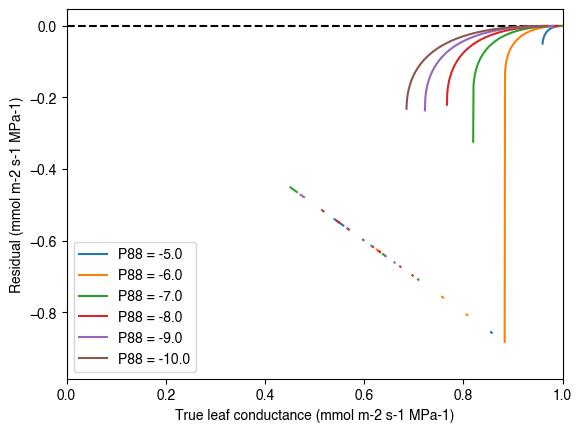

In [7]:
P88_values = np.linspace(-5.,-10., 6)

conductance_models = []

for i in range(len(P88_values)):
    conductance_models.append(cumulative_Weibull_distribution_from_conductance_loss_at_given_water_potentials(k_max,
                                                                                                              P50,
                                                                                                              P88_values[i],
                                                                                                              0.5,
                                                                                                              0.88))

e_leaf_arrays = np.zeros([len(P88_values),len(leaf_psi_true_array)])
k_true_arrays = np.zeros([len(P88_values),len(leaf_psi_true_array)])

for i in range(len(P88_values)):
    for j in range(len(leaf_psi_true_array)):
        e_leaf_arrays[i,j] = conductance_models[i].transpiration(leaf_psi_true_array[j], root_psi, steps = 100)
        k_true_arrays[i,j] = conductance_models[i].conductance(leaf_psi_true_array[j])
        
leaf_psi_predicted_arrays = np.zeros([len(P88_values),len(leaf_psi_true_array)])
leaf_k_predicted_arrays = np.zeros([len(P88_values),len(leaf_psi_true_array)])

for i in range(len(P88_values)):
    for j in range(len(leaf_psi_true_array)):
        leaf_psi_predicted_arrays[i,j] = calc_psi_leaf(root_psi, e_leaf_arrays[i,j], conductance_models[i], acc, N, k_min)
        leaf_k_predicted_arrays[i,j] = conductance_models[i].conductance(leaf_psi_predicted_arrays[i,j])
        
plt.plot([min_psi,0.],[min_psi,0.], color = 'black', linestyle='--')
for i in range(len(P88_values)):
    plt.plot(leaf_psi_true_array, leaf_psi_predicted_arrays[i], label = 'P88 = ' + str(P88_values[i]))
plt.xlabel('True leaf water potential (MPa)')
plt.ylabel('Predictd leaf water potential (MPa)')
plt.legend()
plt.gca().set_aspect('equal')
plt.ylim(min_psi,0.)
plt.xlim(min_psi,0.)
plt.show()

plt.plot([min_psi,0.],[0.,0.], color = 'black', linestyle='--')
for i in range(len(P88_values)):
    plt.plot(leaf_psi_true_array, leaf_psi_predicted_arrays[i] - leaf_psi_true_array, label = 'P88 = ' + str(P88_values[i]))
plt.xlabel('True leaf water potential (MPa)')
plt.ylabel('Residual (MPa)')
plt.legend()
plt.ylim(1.1*min_psi,-1.1*min_psi)
plt.xlim(min_psi,0)
plt.show()

plt.plot([0.,1.],[0.,1.], color = 'black', linestyle='--')
for i in range(len(P88_values)):
    plt.plot(k_true_arrays[i], leaf_k_predicted_arrays[i], label = 'P88 = ' + str(P88_values[i]))
plt.xlabel('True leaf conductance (mmol m-2 s-1 MPa-1)')
plt.ylabel('Predictd leaf conductance (mmol m-2 s-1 MPa-1)')
plt.gca().set_aspect('equal')
plt.ylim(0.,1.)
plt.xlim(0.,1.)
plt.legend()
plt.show()

plt.plot([0.,1.],[0,0], color = 'black', linestyle='--')
for i in range(len(P88_values)):
    plt.plot(k_true_arrays[i], leaf_k_predicted_arrays[i] - k_true_arrays[i], label = 'P88 = ' + str(P88_values[i]))
plt.xlabel('True leaf conductance (mmol m-2 s-1 MPa-1)')
plt.ylabel('Residual (mmol m-2 s-1 MPa-1)')
#plt.ylim(1.1*min_psi,-1.1*min_psi)
plt.xlim(0.,1.)
plt.legend()
plt.show()

## Vairy K_max

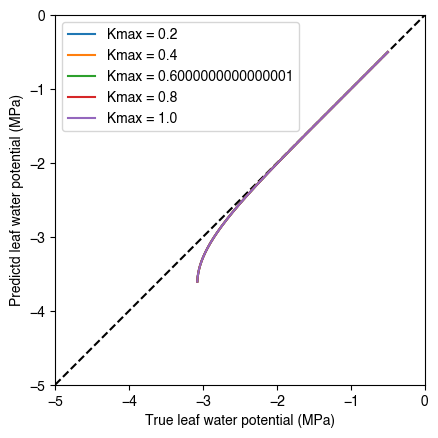

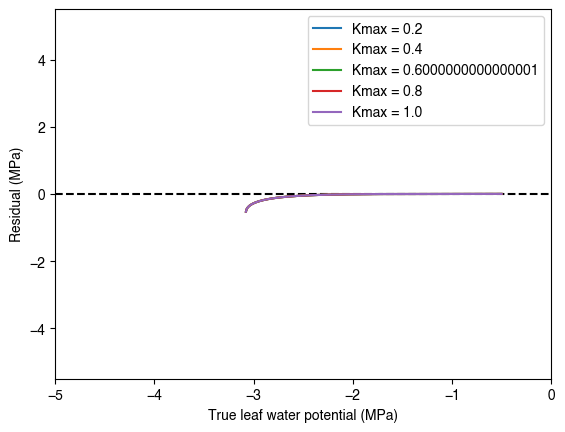

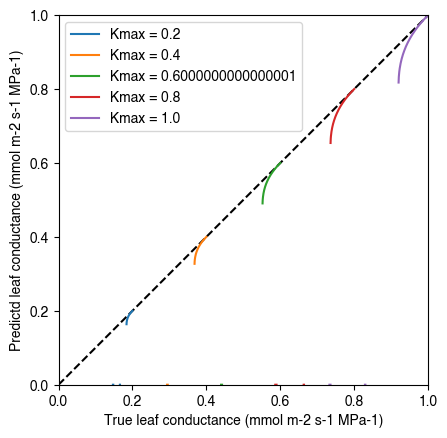

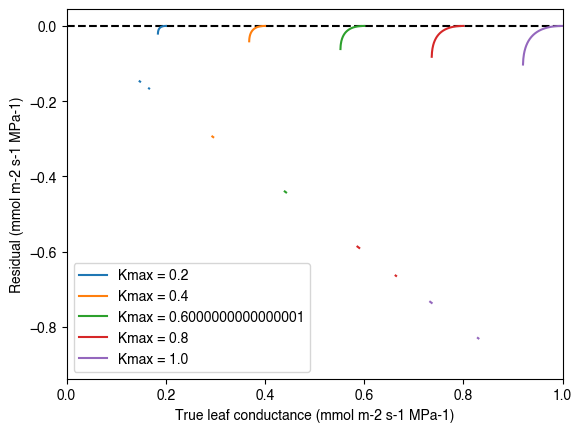

In [8]:
k_max_values = np.linspace(0.2,1., 5)

conductance_models = []

for i in range(len(k_max_values)):
    conductance_models.append(cumulative_Weibull_distribution_from_conductance_loss_at_given_water_potentials(k_max_values[i],
                                                                                                              P50,
                                                                                                              P88,
                                                                                                              0.5,
                                                                                                              0.88))

e_leaf_arrays = np.zeros([len(k_max_values),len(leaf_psi_true_array)])
k_true_arrays = np.zeros([len(k_max_values),len(leaf_psi_true_array)])

for i in range(len(k_max_values)):
    for j in range(len(leaf_psi_true_array)):
        e_leaf_arrays[i,j] = conductance_models[i].transpiration(leaf_psi_true_array[j], root_psi, steps = 100)
        k_true_arrays[i,j] = conductance_models[i].conductance(leaf_psi_true_array[j])

leaf_psi_predicted_arrays = np.zeros([len(k_max_values),len(leaf_psi_true_array)])
leaf_k_predicted_arrays = np.zeros([len(k_max_values),len(leaf_psi_true_array)])

for i in range(len(k_max_values)):
    for j in range(len(leaf_psi_true_array)):
        leaf_psi_predicted_arrays[i,j] = calc_psi_leaf(root_psi, e_leaf_arrays[i,j], conductance_models[i], acc, N, k_min)
        leaf_k_predicted_arrays[i,j] = conductance_models[i].conductance(leaf_psi_predicted_arrays[i,j])
        
plt.plot([min_psi,0.0],[min_psi,0.0], color = 'black', linestyle='--')
for i in range(len(k_max_values)):
    plt.plot(leaf_psi_true_array, leaf_psi_predicted_arrays[i], label = 'Kmax = ' + str(k_max_values[i]))
plt.xlabel('True leaf water potential (MPa)')
plt.ylabel('Predictd leaf water potential (MPa)')
plt.legend()
plt.gca().set_aspect('equal')
plt.ylim(min_psi,0.)
plt.xlim(min_psi,0.)
plt.show()

plt.plot([min_psi,0.],[0.,0.], color = 'black', linestyle='--')
for i in range(len(k_max_values)):
    plt.plot(leaf_psi_true_array, leaf_psi_predicted_arrays[i] - leaf_psi_true_array, label = 'Kmax = ' + str(k_max_values[i]))
plt.xlabel('True leaf water potential (MPa)')
plt.ylabel('Residual (MPa)')
plt.legend()
plt.ylim(1.1*min_psi,-1.1*min_psi)
plt.xlim(min_psi,0)
plt.show()

plt.plot([0.,1.],[0.,1.], color = 'black', linestyle='--')
for i in range(len(k_max_values)):
    plt.plot(k_true_arrays[i], leaf_k_predicted_arrays[i], label = 'Kmax = ' + str(k_max_values[i]))
plt.xlabel('True leaf conductance (mmol m-2 s-1 MPa-1)')
plt.ylabel('Predictd leaf conductance (mmol m-2 s-1 MPa-1)')
plt.gca().set_aspect('equal')
plt.ylim(0.,1.)
plt.xlim(0.,1.)
plt.legend()
plt.show()

plt.plot([0.,1.],[0,0], color = 'black', linestyle='--')
for i in range(len(k_max_values)):
    plt.plot(k_true_arrays[i], leaf_k_predicted_arrays[i] - k_true_arrays[i], label = 'Kmax = ' + str(k_max_values[i]))
plt.xlabel('True leaf conductance (mmol m-2 s-1 MPa-1)')
plt.ylabel('Residual (mmol m-2 s-1 MPa-1)')
#plt.ylim(1.1*min_psi,-1.1*min_psi)
plt.xlim(0.,1.)
plt.legend()
plt.show()

## Vairy root psi

/Users/jb14389/Desktop/Training/Getting started with tree models/profit-optimisation-model/note books/../src/HydraulicConductanceModels/cumulative_Weibull_distribution_model.py:91: RuntimeWarning: invalid value encountered in power
  exponent = - power(water_potentials / sensitivity_parameter, shape_parameter)


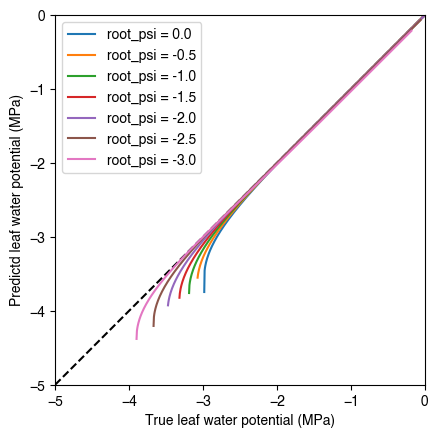

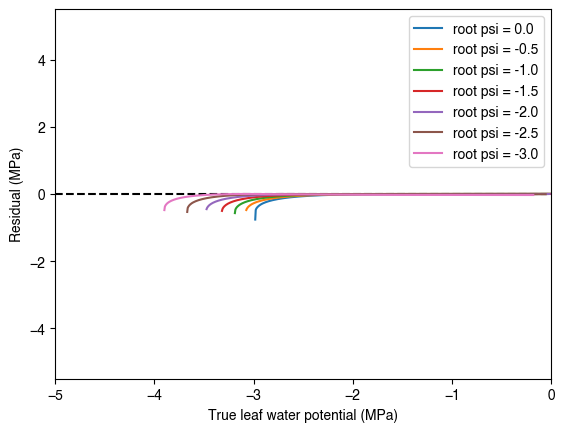

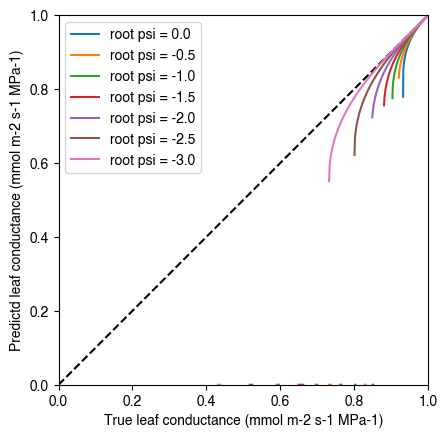

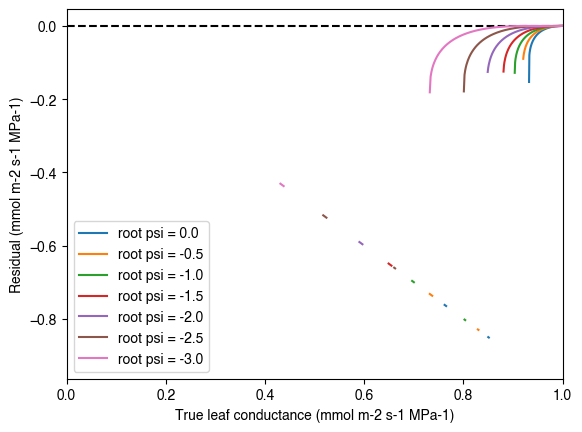

In [9]:
root_psi_values = np.linspace(0., -3., 7)
leaf_psi_true_array = np.linspace(root_psi_values[0], min_psi, 1000)

e_leaf_arrays = np.zeros([len(root_psi_values),len(leaf_psi_true_array)])
k_true_arrays = np.zeros([len(root_psi_values),len(leaf_psi_true_array)])

for i in range(len(root_psi_values)):
    for j in range(len(leaf_psi_true_array)):
        e_leaf_arrays[i,j] = conductance_model.transpiration(leaf_psi_true_array[j], root_psi_values[i], steps = 100)
        k_true_arrays[i,j] = conductance_model.conductance(leaf_psi_true_array[j])
        
leaf_psi_predicted_arrays = np.zeros([len(root_psi_values),len(leaf_psi_true_array)])
leaf_k_predicted_arrays = np.zeros([len(root_psi_values),len(leaf_psi_true_array)])

for i in range(len(root_psi_values)):
    for j in range(len(leaf_psi_true_array)):
        leaf_psi_predicted_arrays[i,j] = calc_psi_leaf(root_psi_values[i], e_leaf_arrays[i,j], conductance_model, acc, N, k_min)
        leaf_k_predicted_arrays[i,j] = conductance_model.conductance(leaf_psi_predicted_arrays[i,j])
        
plt.plot([min_psi,0.0],[min_psi,0.0], color = 'black', linestyle='--')
for i in range(len(root_psi_values)):
    plt.plot(leaf_psi_true_array, leaf_psi_predicted_arrays[i], label = 'root_psi = ' + str(root_psi_values[i]))
plt.xlabel('True leaf water potential (MPa)')
plt.ylabel('Predictd leaf water potential (MPa)')
plt.legend()
plt.gca().set_aspect('equal')
plt.ylim(min_psi,0.)
plt.xlim(min_psi,0.)
plt.show()

plt.plot([min_psi,0.],[0.,0.], color = 'black', linestyle='--')
for i in range(len(root_psi_values)):
    plt.plot(leaf_psi_true_array, leaf_psi_predicted_arrays[i] - leaf_psi_true_array, label = 'root psi = ' + str(root_psi_values[i]))
plt.xlabel('True leaf water potential (MPa)')
plt.ylabel('Residual (MPa)')
plt.legend()
plt.ylim(1.1*min_psi,-1.1*min_psi)
plt.xlim(min_psi,0)
plt.show()

plt.plot([0.,1.],[0.,1.], color = 'black', linestyle='--')
for i in range(len(root_psi_values)):
    plt.plot(k_true_arrays[i], leaf_k_predicted_arrays[i], label = 'root psi = ' + str(root_psi_values[i]))
plt.xlabel('True leaf conductance (mmol m-2 s-1 MPa-1)')
plt.ylabel('Predictd leaf conductance (mmol m-2 s-1 MPa-1)')
plt.gca().set_aspect('equal')
plt.ylim(0.,1.)
plt.xlim(0.,1.)
plt.legend()
plt.show()

plt.plot([0.,1.],[0,0], color = 'black', linestyle='--')
for i in range(len(root_psi_values)):
    plt.plot(k_true_arrays[i], leaf_k_predicted_arrays[i] - k_true_arrays[i], label = 'root psi = ' + str(root_psi_values[i]))
plt.xlabel('True leaf conductance (mmol m-2 s-1 MPa-1)')
plt.ylabel('Residual (mmol m-2 s-1 MPa-1)')
#plt.ylim(1.1*min_psi,-1.1*min_psi)
plt.xlim(0.,1.)
plt.legend()
plt.show()

# Imporving the aproxmation

## Shifting the water potential at wich the Taylor series is evaluated

The first thing we are going to try is to move the refrence point at which the taylor expansion is made to the mean of the leaf and root water potential. The aim here is to better aproximate the whole integral range rather than that around the leaf water potential.

In [10]:
def calc_psi_leaf_mean_used(psi_sat, e_leaf, conductance_model, acc, N = 100, k_min = 0.0001, debug = False):
    
    k_current = conductance_model.conductance(psi_sat)
    
    psi_leaf = cp.copy(psi_sat)
    
    for itter in range(N):
        
        # Needed to avoid divide by zero.
        if k_current < k_min:
            return np.nan
        
        psi_ref = (psi_leaf + psi_sat)/2
        k_ref = conductance_model.conductance(psi_ref)
        
        if debug:
            print("\n -- ", itter, " -- ")
            print("k_current: ", k_current)
            print("psi_current: ", psi_leaf)
            print("k_ref: ", k_ref)
            print("psi_ref: ", psi_ref)
        
        k_old = cp.copy(k_current)
        
        psi_leaf = psi_sat - (e_leaf / k_ref)
        
        k_current = conductance_model.conductance(psi_leaf)
        
        if np.abs(k_current - k_old) < acc :
            if debug:
                print("k_out: ", k_current)
                print("n = ", itter, " of ", N)
            return psi_leaf
        
       
        
    if debug:
        print("n = ", itter, " of ", N)
    return psi_leaf

Testing this for a single leaf water potential

In [11]:
leaf_psi_predicted = calc_psi_leaf_mean_used(root_psi, e_leaf, conductance_model, acc, N, debug = True)

print("\nPredicted psi: ", leaf_psi_predicted, " MPa")


 --  0  -- 
k_current:  0.9999966566335279
psi_current:  -0.5
k_ref:  0.9999966566335279
psi_ref:  -0.5

 --  1  -- 
k_current:  0.9341241646867382
psi_current:  -2.9675954366378026
k_ref:  0.9965939040507354
psi_ref:  -1.7337977183189013

 --  2  -- 
k_current:  0.9331112157078242
psi_current:  -2.9760207508115872
k_ref:  0.9965476175642372
psi_ref:  -1.7380103754057936

 --  3  -- 
k_current:  0.9330973058898577
psi_current:  -2.9761357541481384
k_ref:  0.9965469822229901
psi_ref:  -1.7380678770740692
k_out:  0.9330971149351652
n =  3  of  100

Predicted psi:  -2.976137332790396  MPa


## Comparison to applyng taylor series expansion at the previous leaf water potential

Here we aproximate the 

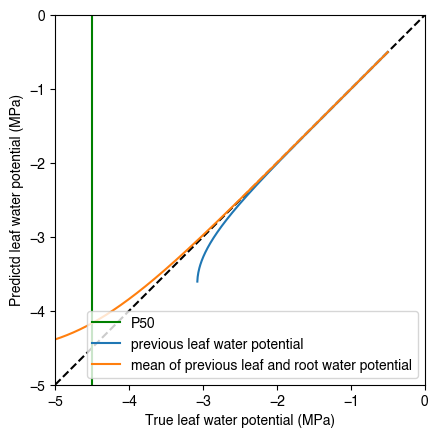

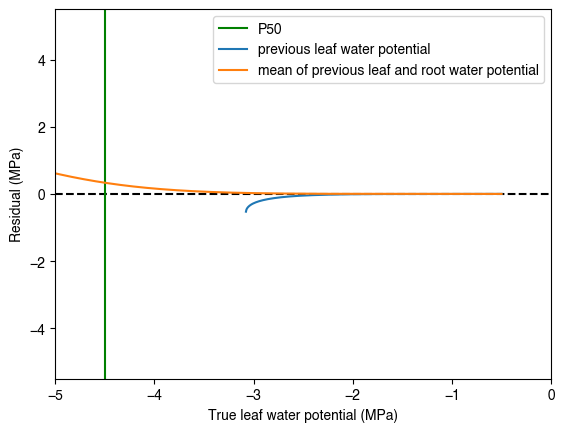

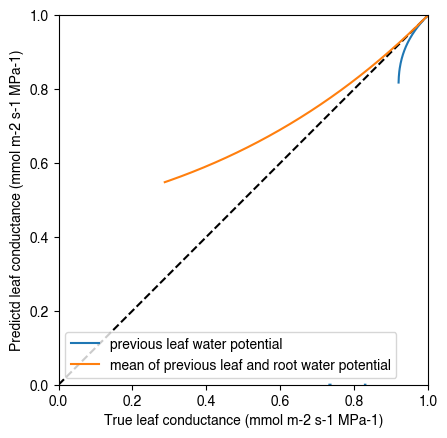

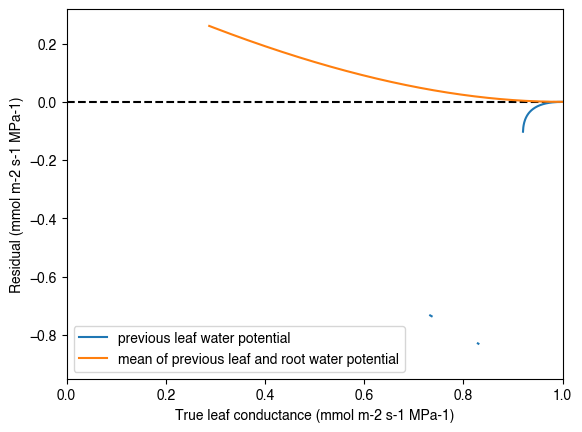

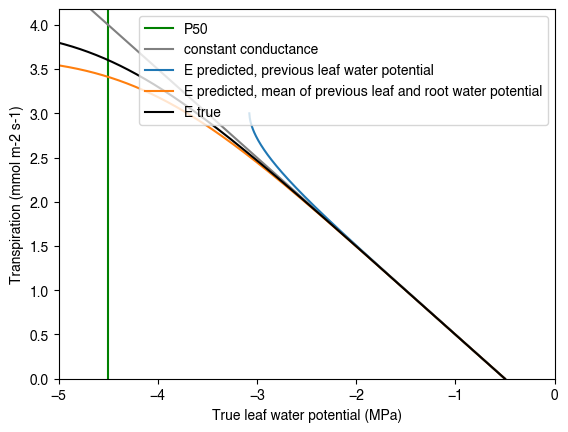

In [12]:
k_min = 0.000001
min_psi = -5.0
root_psi = -0.5 # MPa
leaf_psi_true_array = np.linspace(root_psi, min_psi, 1000)

e_leaf_array = np.zeros(len(leaf_psi_true_array))
k_true_array = np.zeros(len(leaf_psi_true_array))

for i in range(len(leaf_psi_true_array)):
    e_leaf_array[i] = conductance_model.transpiration(leaf_psi_true_array[i], root_psi, steps = 100)
    k_true_array[i] = conductance_model.conductance(leaf_psi_true_array[i])

leaf_psi_predicted_array = np.zeros((len(leaf_psi_true_array),2))
k_predicted_array = np.zeros((len(leaf_psi_true_array),2))
e_predicted_array = np.zeros((len(leaf_psi_true_array),2))

for i in range(len(leaf_psi_true_array)):
    leaf_psi_predicted_array[i,0] = calc_psi_leaf(root_psi, e_leaf_array[i], conductance_model, acc, N, k_min)
    leaf_psi_predicted_array[i,1] = calc_psi_leaf_mean_used(root_psi, e_leaf_array[i], conductance_model, acc, N, k_min)
    
    k_predicted_array[i,0] = conductance_model.conductance(leaf_psi_predicted_array[i,0])
    k_predicted_array[i,1] = conductance_model.conductance(leaf_psi_predicted_array[i,1])
    
    e_predicted_array[i,0] = conductance_model.transpiration(leaf_psi_predicted_array[i,0], root_psi, steps = 100)
    e_predicted_array[i,1] = conductance_model.transpiration(leaf_psi_predicted_array[i,1], root_psi, steps = 100)
    

plt.plot([min_psi,0],[min_psi,0], color = 'black', linestyle='--')
plt.plot([P50,P50],[0,min_psi], color = 'g', label = 'P50')
plt.plot(leaf_psi_true_array, leaf_psi_predicted_array[:,0], label = "previous leaf water potential")
plt.plot(leaf_psi_true_array, leaf_psi_predicted_array[:,1], label = "mean of previous leaf and root water potential")
plt.xlabel('True leaf water potential (MPa)')
plt.ylabel('Predictd leaf water potential (MPa)')
plt.gca().set_aspect('equal')
plt.ylim(min_psi,0)
plt.xlim(min_psi,0)
plt.legend()
plt.show()

plt.plot([min_psi,0],[0,0], color = 'black', linestyle='--')
plt.plot([P50,P50],[1.1*min_psi,-1.1*min_psi], color = 'g', label = 'P50')
plt.plot(leaf_psi_true_array, leaf_psi_predicted_array[:,0] - leaf_psi_true_array, label = "previous leaf water potential")
plt.plot(leaf_psi_true_array, leaf_psi_predicted_array[:,1] - leaf_psi_true_array, label = "mean of previous leaf and root water potential")
plt.xlabel('True leaf water potential (MPa)')
plt.ylabel('Residual (MPa)')
plt.ylim(1.1*min_psi,-1.1*min_psi)
plt.xlim(min_psi,0)
plt.legend()
plt.show()

plt.plot([0.,1.],[0.,1.], color = 'black', linestyle='--')
plt.plot(k_true_array, k_predicted_array[:,0], label = "previous leaf water potential")
plt.plot(k_true_array, k_predicted_array[:,1], label = "mean of previous leaf and root water potential")
plt.xlabel('True leaf conductance (mmol m-2 s-1 MPa-1)')
plt.ylabel('Predictd leaf conductance (mmol m-2 s-1 MPa-1)')
plt.gca().set_aspect('equal')
plt.ylim(0.,1.)
plt.xlim(0.,1.)
plt.legend()
plt.show()

plt.plot([0.,1.],[0,0], color = 'black', linestyle='--')
plt.plot(k_true_array, k_predicted_array[:,0] - k_true_array, label = "previous leaf water potential")
plt.plot(k_true_array, k_predicted_array[:,1] - k_true_array, label = "mean of previous leaf and root water potential")
plt.xlabel('True leaf conductance (mmol m-2 s-1 MPa-1)')
plt.ylabel('Residual (mmol m-2 s-1 MPa-1)')
#plt.ylim(1.1*min_psi,-1.1*min_psi)
plt.xlim(0.,1.)
plt.legend()
plt.show()

plt.plot([P50,P50],[0,1.1*e_leaf_array[-1]], color = 'g', label = 'P50')
plt.plot([min_psi,leaf_psi_true_array[0]],[k_max*(leaf_psi_true_array[0]-min_psi),0], color = 'grey', label = 'constant conductance')
plt.plot(leaf_psi_true_array, e_predicted_array[:,0], label = 'E predicted, previous leaf water potential')
plt.plot(leaf_psi_true_array, e_predicted_array[:,1], label = 'E predicted, mean of previous leaf and root water potential')
plt.plot(leaf_psi_true_array, e_leaf_array, color = 'black', label = 'E true')
plt.xlabel('True leaf water potential (MPa)')
plt.ylabel('Transpiration (mmol m-2 s-1)')
plt.xlim(min_psi,0)
plt.ylim(0,1.1*e_leaf_array[-1])
plt.legend()
plt.show()

## Using the 1st order taylor series expansion

In the paper the approximation is described as equivelent to a Taylor series aproximation. Specificaly the equation for transpiration is the integral over the zeroth order Taylor series aproximation of the conductance equation evaluated at the previous water potential. The function bellow expands this premiss by using a higher order Taylor expansion to aproximate the conductance equation.

Note: The code bellow uses the mean of the root and current leaf water potential as the refrence point for the Taylor expansion.

In [13]:
def zeroth_order_aproximation(psi_sat, e_leaf, k_ref):
    
    psi_out = psi_sat - (e_leaf/k_ref)
    
    return psi_out

def first_order_approximation(psi_sat, e_leaf, k_ref, psi_ref, conductance_model, debug = False):
    
    b = conductance_model.sensitivity_parameter
    c = conductance_model.shape_parameter
    
    if(debug):
        print("\nb = ", b)
        print("c = ", c)
    
    # First order derivatives
    k1_ref = k_ref * (-(c/b)*np.power(psi_ref/b,c-1))
    
    if(debug):
        print("\nk1_ref = ", k1_ref)
    
    # Constants in integral
    # E = [G*psi + H*psi^2]_{psi_root}^{psi_leaf}
    G = k_ref - k1_ref*psi_ref
    H = 0.5*k1_ref
    
    if(debug):
        print("\nG = ", G)
        print("H = ", H)
    
    # Constants in quadratic
    # 0 = A*psi_leaf^2 + B*psi_leaf + C
    A = H
    B = G
    C = H*psi_sat**2 + G*psi_sat - e_leaf
    
    if(debug):
        print("\nA = ", A)
        print("B = ", B)
        print("C = ", C)
        print("B^2 = ", B**2)
        print("4AC = ", 4*A*C)
        print("B^2 - 4AC = ", B**2 - 4*A*C)
    
    # Solve quadratic
    psi_leaf_solution_1 = -(-B + np.sqrt(B**2 - 4*A*C))/(2*A)
    psi_leaf_solution_2 = -(-B - np.sqrt(B**2 - 4*A*C))/(2*A)
    
    if(debug):
        print("\npsi_leaf_solution_1 = ", psi_leaf_solution_1)
        print("psi_leaf_solution_2 = ", psi_leaf_solution_2)
    
    return min(psi_leaf_solution_1, psi_leaf_solution_2)



def calc_psi_leaf_nth_order(psi_sat, e_leaf, conductance_model, acc, order, N = 100, k_min = 0.0001, debug = False):
    
    k_current = conductance_model.conductance(psi_sat)
    
    psi_leaf = cp.copy(psi_sat)
    
    for itter in range(N):
        
        # Needed to avoid divide by zero.
        if k_current < k_min:
            return np.nan
        
        psi_ref = (psi_leaf + psi_sat)/2
        k_ref = conductance_model.conductance(psi_ref)
        
        if debug:
            print("\n -- ", itter, " -- ")
            print("k_current: ", k_current)
            print("psi_current: ", psi_leaf)
            print("k_ref: ", k_ref)
            print("psi_ref: ", psi_ref)
        
        k_old = cp.copy(k_current)
        
        match order:
            case 0:
                psi_leaf = zeroth_order_aproximation(psi_sat, e_leaf, k_ref)
                
            case 1:
                psi_leaf = first_order_approximation(psi_sat, e_leaf, k_ref, psi_ref, conductance_model, debug)
        
        k_current = conductance_model.conductance(psi_leaf)
        
        if np.abs(k_current - k_old) < acc :
            if debug:
                print("k_out: ", k_current)
                print("n = ", itter, " of ", N)
            return psi_leaf
        
       
        
    if debug:
        print("n = ", itter, " of ", N)
    return psi_leaf

Test by predicting a single leaf water potential.

In [14]:
leaf_psi_predicted = calc_psi_leaf_nth_order(root_psi, e_leaf, conductance_model, acc, 1, N, debug = True)

print("\nPredicted psi: ", leaf_psi_predicted, " MPa")


 --  0  -- 
k_current:  0.9999966566335279
psi_current:  -0.5
k_ref:  0.9999966566335279
psi_ref:  -0.5

b =  -4.805975075105169
c =  5.571582380243554

k1_ref =  3.725562117433062e-05

G =  1.000015284444115
H =  1.862781058716531e-05

A =  1.862781058716531e-05
B =  1.000015284444115
C =  -2.9675901718313638
B^2 =  1.0000305691218443
4AC =  -0.00022111883048483202
B^2 - 4AC =  1.000251687952329

psi_leaf_solution_1 =  -2.9673807926953915
psi_leaf_solution_2 =  53686.96205986315

 --  1  -- 
k_current:  0.9341498137239366
psi_current:  -2.9673807926953915
k_ref:  0.9965950765791003
psi_ref:  -1.7336903963476957

b =  -4.805975075105169
c =  5.571582380243554

k1_ref =  0.010923794455484305

G =  1.0155335541182495
H =  0.005461897227742153

A =  0.005461897227742153
B =  1.0155335541182495
C =  -2.9739884893141424
B^2 =  1.0313083995400436
4AC =  -0.06497447794048795
B^2 - 4AC =  1.0962828774805315

psi_leaf_solution_1 =  -2.883771382731537
psi_leaf_solution_2 =  188.81432111188712



## Comparing the higer order taylor series aproximation

The code bellow compares the new first order taylor series expansion with the two previous zeroth order aproximations of leaf water potential.

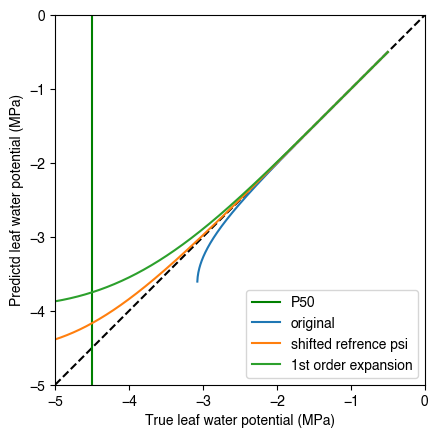

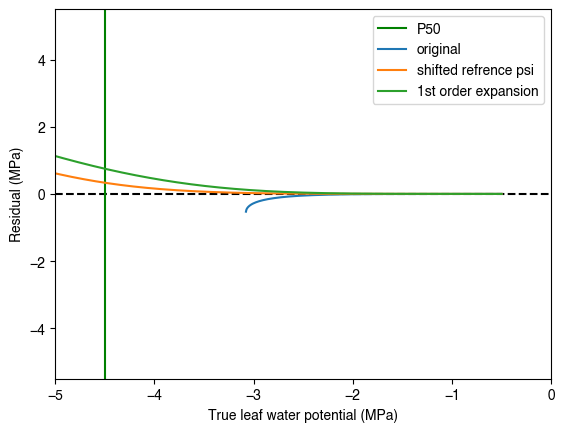

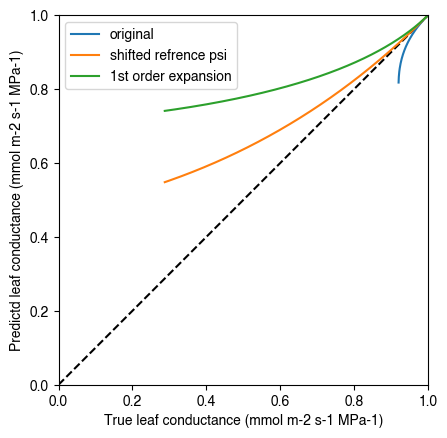

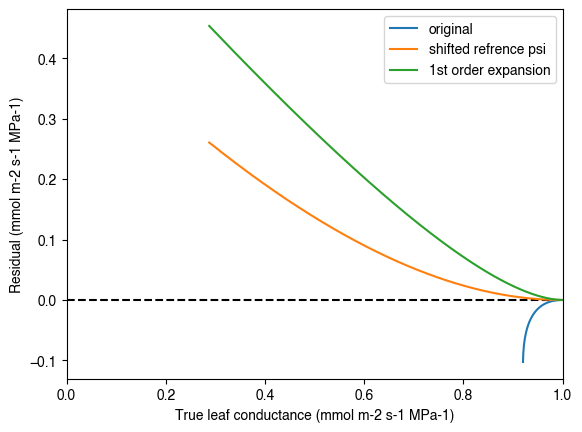

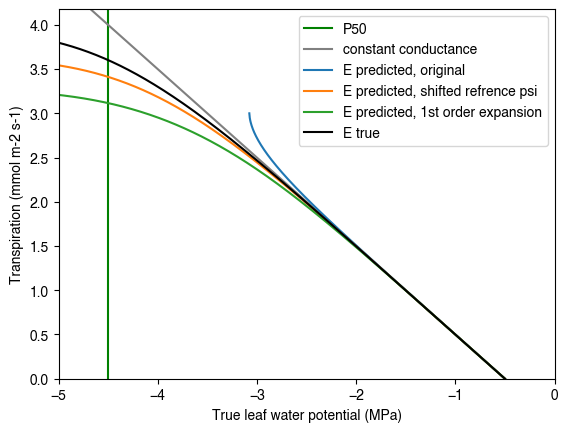

In [15]:
k_min = 0.000001
min_psi = -5.0
root_psi = -0.5 # MPa
leaf_psi_true_array = np.linspace(root_psi, min_psi, 1000)

e_leaf_array = np.zeros(len(leaf_psi_true_array))
k_true_array = np.zeros(len(leaf_psi_true_array))

for i in range(len(leaf_psi_true_array)):
    e_leaf_array[i] = conductance_model.transpiration(leaf_psi_true_array[i], root_psi, steps = 100)
    k_true_array[i] = conductance_model.conductance(leaf_psi_true_array[i])

leaf_psi_predicted_array = np.zeros((len(leaf_psi_true_array),3))
k_predicted_array = np.zeros((len(leaf_psi_true_array),3))
e_predicted_array = np.zeros((len(leaf_psi_true_array),3))

for i in range(len(leaf_psi_true_array)):
    leaf_psi_predicted_array[i,0] = calc_psi_leaf(root_psi, e_leaf_array[i], conductance_model, acc, N)
    leaf_psi_predicted_array[i,1] = calc_psi_leaf_mean_used(root_psi, e_leaf_array[i], conductance_model, acc, N, k_min)
    leaf_psi_predicted_array[i,2] = calc_psi_leaf_nth_order(root_psi, e_leaf_array[i], conductance_model, acc, 1, N, k_min)
    
    k_predicted_array[i,0] = conductance_model.conductance(leaf_psi_predicted_array[i,0])
    k_predicted_array[i,1] = conductance_model.conductance(leaf_psi_predicted_array[i,1])
    k_predicted_array[i,2] = conductance_model.conductance(leaf_psi_predicted_array[i,2])
    
    e_predicted_array[i,0] = conductance_model.transpiration(leaf_psi_predicted_array[i,0], root_psi, steps = 100)
    e_predicted_array[i,1] = conductance_model.transpiration(leaf_psi_predicted_array[i,1], root_psi, steps = 100)
    e_predicted_array[i,2] = conductance_model.transpiration(leaf_psi_predicted_array[i,2], root_psi, steps = 100)
    

plt.plot([min_psi,0],[min_psi,0], color = 'black', linestyle='--')
plt.plot([P50,P50],[0,min_psi], color = 'g', label = 'P50')
plt.plot(leaf_psi_true_array, leaf_psi_predicted_array[:,0], label = "original")
plt.plot(leaf_psi_true_array, leaf_psi_predicted_array[:,1], label = "shifted refrence psi")
plt.plot(leaf_psi_true_array, leaf_psi_predicted_array[:,2], label = "1st order expansion")
plt.xlabel('True leaf water potential (MPa)')
plt.ylabel('Predictd leaf water potential (MPa)')
plt.gca().set_aspect('equal')
plt.ylim(min_psi,0)
plt.xlim(min_psi,0)
plt.legend()
plt.show()

plt.plot([min_psi,0],[0,0], color = 'black', linestyle='--')
plt.plot([P50,P50],[1.1*min_psi,-1.1*min_psi], color = 'g', label = 'P50')
plt.plot(leaf_psi_true_array, leaf_psi_predicted_array[:,0] - leaf_psi_true_array, label = "original")
plt.plot(leaf_psi_true_array, leaf_psi_predicted_array[:,1] - leaf_psi_true_array, label = "shifted refrence psi")
plt.plot(leaf_psi_true_array, leaf_psi_predicted_array[:,2] - leaf_psi_true_array, label = "1st order expansion")
plt.xlabel('True leaf water potential (MPa)')
plt.ylabel('Residual (MPa)')
plt.ylim(1.1*min_psi,-1.1*min_psi)
plt.xlim(min_psi,0)
plt.legend()
plt.show()

plt.plot([0.,1.],[0.,1.], color = 'black', linestyle='--')
plt.plot(k_true_array, k_predicted_array[:,0], label = "original")
plt.plot(k_true_array, k_predicted_array[:,1], label = "shifted refrence psi")
plt.plot(k_true_array, k_predicted_array[:,2], label = "1st order expansion")
plt.xlabel('True leaf conductance (mmol m-2 s-1 MPa-1)')
plt.ylabel('Predictd leaf conductance (mmol m-2 s-1 MPa-1)')
plt.gca().set_aspect('equal')
plt.ylim(0.,1.)
plt.xlim(0.,1.)
plt.legend()
plt.show()

plt.plot([0.,1.],[0,0], color = 'black', linestyle='--')
plt.plot(k_true_array, k_predicted_array[:,0] - k_true_array, label = "original")
plt.plot(k_true_array, k_predicted_array[:,1] - k_true_array, label = "shifted refrence psi")
plt.plot(k_true_array, k_predicted_array[:,2] - k_true_array, label = "1st order expansion")
plt.xlabel('True leaf conductance (mmol m-2 s-1 MPa-1)')
plt.ylabel('Residual (mmol m-2 s-1 MPa-1)')
#plt.ylim(1.1*min_psi,-1.1*min_psi)
plt.xlim(0.,1.)
plt.legend()
plt.show()

plt.plot([P50,P50],[0,1.1*e_leaf_array[-1]], color = 'g', label = 'P50')
plt.plot([min_psi,leaf_psi_true_array[0]],[k_max*(leaf_psi_true_array[0]-min_psi),0], color = 'grey', label = 'constant conductance')
plt.plot(leaf_psi_true_array, e_predicted_array[:,0], label = 'E predicted, original')
plt.plot(leaf_psi_true_array, e_predicted_array[:,1], label = 'E predicted, shifted refrence psi')
plt.plot(leaf_psi_true_array, e_predicted_array[:,2], label = 'E predicted, 1st order expansion')
plt.plot(leaf_psi_true_array, e_leaf_array, color = 'black', label = 'E true')
plt.xlabel('True leaf water potential (MPa)')
plt.ylabel('Transpiration (mmol m-2 s-1)')
plt.xlim(min_psi,0)
plt.ylim(0,1.1*e_leaf_array[-1])
plt.legend()
plt.show()